In [111]:
# You can install the packages we use here
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/DIAGNijmegen/pathology-whole-slide-data (to revision main) to /tmp/pip-req-build-uuigukg3
  Running command git clone --filter=blob:none --quiet https://github.com/DIAGNijmegen/pathology-whole-slide-data /tmp/pip-req-build-uuigukg3
  Resolved https://github.com/DIAGNijmegen/pathology-whole-slide-data to commit 271fb01f01825d2213fe8759295bfda8a0b524ef
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [112]:
# import the necessary packages
from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
from wholeslidedata.annotation.callbacks import ScalingAnnotationCallback
from wholeslidedata import WholeSlideImage
import shapely
from rasterio import features
import rasterio
import geopandas as gpd
import numpy as np

In [113]:
def load_mask(path, spacing): 
	mask_obj = WholeSlideImage(path, backend='asap') 
	mask= mask_obj.get_slide(spacing) 
	return mask.squeeze()


In [114]:
def mask_to_polygons_layer(mask):
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask > 0),
                                        transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        all_polygons.append(shapely.geometry.shape(shape).buffer(0))

    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    return all_polygons


In [115]:
def cell_density(tumor_poly, cells, spacing):
    cell_points = [cell._geometry  for cell in cells]
    a = gpd.GeoDataFrame(cell_points).set_geometry(0)
    b = gpd.GeoDataFrame([tumor_poly]).set_geometry(0)
    check = gpd.tools.sjoin(a, b, how='left')
    counts = sum(check['index_right'].notna())
    return counts/(tumor_poly.area * spacing * 10 ** -6)


In [116]:
# Load the tissue tumor mask. Its a pyramid tif and the lowest level contains pixel spacing 2.0. We will load this on spacing 2.0.
mask_path = 'files/tumor_map.tif'
mask = load_mask(mask_path, 2.0)

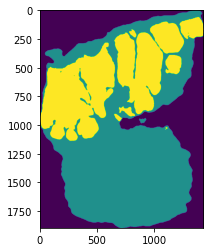

In [131]:
# Check if the mask is loaded correctly and visualize it, we see both the tissue mask and tumor mask.
import matplotlib.pyplot as plt
plt.imshow(mask)
plt.show()

# 0 = No tissue (purple)
# 1 = Tissue (petrol green)
# 2 = Tumor (yellow)

In [133]:
# Lets convert the tumor mask to a polygon
tumor_poly = mask_to_polygons_layer(mask==2)

In [119]:
# Now we load the cells from our ASAP compatible XML. 
cell_detections = 'files/cell_detections.xml'
# We add a callback to scale the coordinates of the annotations to the same level as the mask, so we go from 0.24 um/pixel to 2.0 um/pixel
scaler = ScalingAnnotationCallback(1/8)
cells = WholeSlideAnnotation(cell_detections, callbacks=(scaler,))
print('Cells loaded:', len(cells.annotations))

Cells loaded: 33390


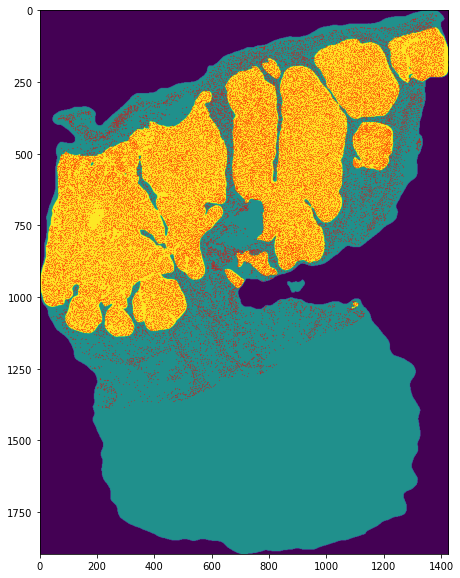

In [137]:
# Make an overlay of the complete mask and the cells.
fig, ax = plt.subplots(figsize=(10, 10)) 
cell_points = [cell._geometry  for cell in cells.annotations]
a = gpd.GeoDataFrame(cell_points).set_geometry(0)
a.plot(ax=ax, color='red', marker=".", markersize=0.1) # Plot the cells in red

# Flip the Y-axis
ymin, ymax = ax.get_ylim()

plt.imshow(mask)     # Plot the mask, see color scheme two cells above.
plt.show()

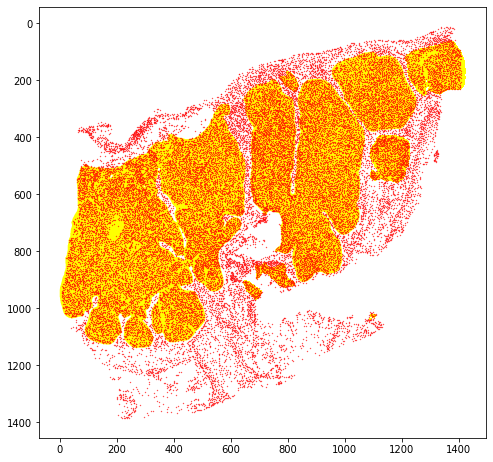

In [139]:
# Plot both the tumor polygons and the cells points. We use the plot functions of Geopandas for this. 
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.set_ylim(ymax, ymin)
a = gpd.GeoDataFrame(cell_points).set_geometry(0)
b = gpd.GeoDataFrame([tumor_poly]).set_geometry(0)
# Plot the tumor polygons in yellow
b.plot(ax=ax, color='yellow', linewidth=1)
# # Plot on top the cell points in red
a.plot(ax=ax, color='red', markersize=0.1)

# Show the combined plot
plt.show()

In [140]:
# Now lets calculate the cell density now we have confirmed a good registration of our cells and tumor area.
cell_dens = cell_density(tumor_poly, cells.annotations, 2.0)
print(f"Cells per mm2 tumor area: {int(cell_dens)})")

Cells per mm2 tumor area: 18072)
